# Environments

- python=3.8
- pytorch=1.13


In [1]:
from transform import ToTensor
from models import res50_ASPP_lorm
import basic_function as func
import torch
import numpy as np
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt

/home/zxl/anaconda3/envs/urss/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def net_process( model, image, mean, std=None, flip=False):
    input = torch.from_numpy(image.transpose((2, 0, 1))).float()
    if std is None:
        for t, m in zip(input, mean):
            t.sub_(m)
    else:
        for t, m, s in zip(input, mean, std):
            t.sub_(m).div_(s)
    input = input.unsqueeze(0).cuda()
    if flip:
        input = torch.cat([input, input.flip(3)], 0)
    with torch.no_grad():
        output = model.forward_eval(input)
    _, _, h_i, w_i = input.shape
    _, _, h_o, w_o = output.shape
    if (h_o != h_i) or (w_o != w_i):
        output = F.interpolate(output, (h_i, w_i), mode='bilinear', align_corners=True)
    output = F.softmax(output, dim=1)
    if flip:
        output = (output[0] + output[1].flip(2)) / 2
    else:
        output = output[0]
    output = output.data.cpu().numpy()
    output = output.transpose(1, 2, 0)
    
    return output


def scale_process( model, image, classes, crop_h, crop_w, h, w, mean, std=None, stride_rate=2/3): # crop_h crop_w 465
    ori_h, ori_w, _ = image.shape
    pad_h = max(crop_h - ori_h, 0)
    pad_w = max(crop_w - ori_w, 0)
    pad_h_half = int(pad_h / 2)
    pad_w_half = int(pad_w / 2)
    if pad_h > 0 or pad_w > 0:
        image = cv2.copyMakeBorder(image, pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half, cv2.BORDER_CONSTANT, value=mean) # pad the image to 
    new_h, new_w, _ = image.shape
    stride_h = int(np.ceil(crop_h*stride_rate))
    stride_w = int(np.ceil(crop_w*stride_rate))
    grid_h = int(np.ceil(float(new_h-crop_h)/stride_h) + 1)
    grid_w = int(np.ceil(float(new_w-crop_w)/stride_w) + 1)
    prediction_crop = np.zeros((new_h, new_w, classes), dtype=float)
    count_crop = np.zeros((new_h, new_w), dtype=float)
    #debug()
    i = 0
    for index_h in range(0, grid_h):
        for index_w in range(0, grid_w):
            i +=1 
            s_h = index_h * stride_h
            e_h = min(s_h + crop_h, new_h)
            s_h = e_h - crop_h
            s_w = index_w * stride_w
            e_w = min(s_w + crop_w, new_w)
            s_w = e_w - crop_w
            image_crop = image[s_h:e_h, s_w:e_w].copy()
            count_crop[s_h:e_h, s_w:e_w] += 1
            prediction_crop[s_h:e_h, s_w:e_w, :] += net_process( model, image_crop, mean, std)
            # print(i,time.time()-t1)
    prediction_crop /= np.expand_dims(count_crop, 2)
    prediction_crop = prediction_crop[pad_h_half:pad_h_half+ori_h, pad_w_half:pad_w_half+ori_w]
    
    prediction = cv2.resize(prediction_crop, (w, h), interpolation=cv2.INTER_LINEAR)
    return prediction

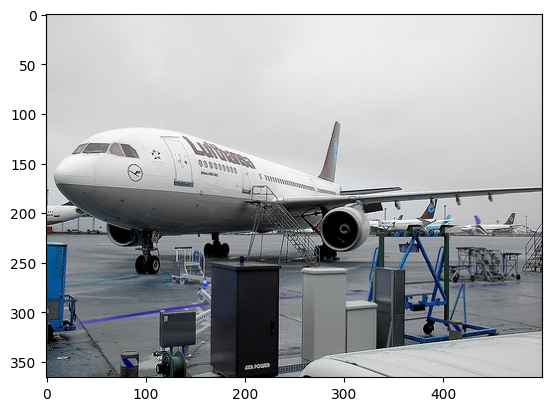

In [3]:
checkpoint_path = 'log/train_deeplabv2_r50/last_checkpoint.pth'
image_path = "dataset/ScribbleSup/VOC2012/JPEGImages/2007_000033.jpg"

value_scale = 255
mean = [0.485, 0.456, 0.406]
mean = [item * value_scale for item in mean]
std = [0.229, 0.224, 0.225]
std = [item * value_scale for item in std]

image = cv2.imread(image_path)
input1 = torch.from_numpy(image.transpose((2, 0, 1))).float()
plt.imshow(image)


In [4]:
model = res50_ASPP_lorm.Res_Deeplab(num_classes=21,layers=50)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.cuda()
model.eval()

ResNet_lorm(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): SynchronizedBatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        

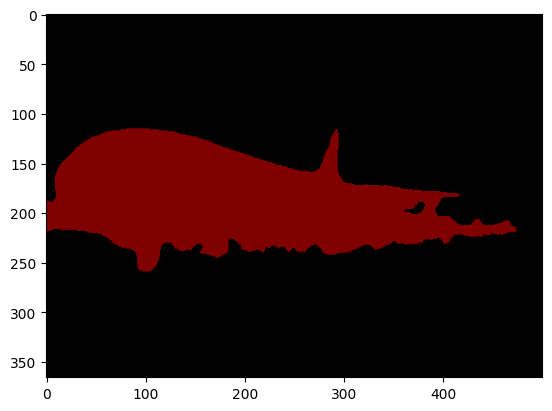

In [5]:
scales = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
crop_h,crop_w = 465,465
image = np.transpose(input1.numpy(),(1,2,0)) # c,h,w-> h,w,c
h,w,_ =image.shape
classes = 21
base_size = 512
prediction = np.zeros((h,w,classes),dtype=float)
for scale in scales:
    long_size = round(scale * base_size) # 256
    new_h = long_size
    new_w = long_size # 长边对齐缩放
    if h > w:
        new_w = round(long_size/float(h)*w)
    else:
        new_h = round(long_size/float(w)*h)
    image_scale = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR) # scale the image maintaining the w-h ratio 
    prediction += scale_process(model, image_scale, classes, crop_h, crop_w, h, w, mean, std)
prediction /= len(scales)
prediction = np.argmax(prediction, axis=2)
pred=torch.from_numpy(prediction)
pred=torch.unsqueeze(pred,0)
mask = func.get_mask_pallete ( pred[0].cpu ().numpy (), 'pascal_voc' )
mask.save('result.png')
plt.imshow(mask)